# Réseaux neuronal multicouche à Perceptron

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras import layers, models, callbacks, optimizers, losses

In [50]:
IMAGE_SIZE = 64

X = np.load("./data/X.npy")
X = X.reshape(len(X), 64*64) # mise a plat de l image

y_ = np.load("./data/Y.npy")

# Équivalence encodage/traduction
dic_equiv = {0:9, 1:0, 2:7, 3:6, 4:1, 5:8, 6:4, 7:3, 8:2 , 9:5} 

y = np.zeros(len(y_))
for k in range(len(y)):
    a = y_[k]
    y[k] = int(dic_equiv[np.where(a==1)[0][0]])
y = y.astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=420)

X_train_cnn = X_train.reshape(-1, 64, 64, 1)
X_test_cnn = X_test.reshape(-1, 64, 64, 1)

# "Augmentation" des données
data_augmentation = models.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
])

model = models.Sequential([
    layers.Input(shape=(64, 64, 1)),
    data_augmentation,
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    # Réduction du surapprentissage
    layers.GlobalAveragePooling2D(), 
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(10, activation='softmax')
])

early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=12, restore_best_weights=True
)

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    'best_model.keras', monitor='val_accuracy', save_best_only=True
)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    X_train_cnn, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_test_cnn, y_test),
    callbacks=[lr_scheduler, checkpoint, early_stop]
)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2775 - loss: 2.0921 - val_accuracy: 0.0950 - val_loss: 2.5153 - learning_rate: 0.0010
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4858 - loss: 1.5206 - val_accuracy: 0.1221 - val_loss: 2.6125 - learning_rate: 0.0010
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6656 - loss: 1.0371 - val_accuracy: 0.0717 - val_loss: 2.9987 - learning_rate: 0.0010
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7807 - loss: 0.6875 - val_accuracy: 0.1376 - val_loss: 3.4455 - learning_rate: 0.0010
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8642 - loss: 0.4651 - val_accuracy: 0.0950 - val_loss: 4.4724 - learning_rate: 0.0010
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8698 - loss: 0.4297
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8816 - loss: 0.4028 - val_ac

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


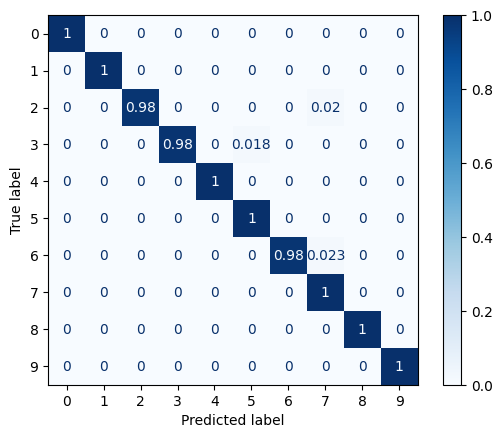

In [52]:
y_pred_probs = model.predict(X_test_cnn)

y_pred = np.argmax(y_pred_probs, axis=1)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues, display_labels=range(0, 10), normalize="true")
plt.show()